In [1]:
from __future__ import print_function, division
import mdtraj as md
from mdtraj.utils import ensure_type
from mdtraj.geometry import compute_distances, compute_angles
from mdtraj.geometry import _geometry
import os
import sys
import numpy as np
import scipy 
from scipy import optimize
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import math
import itertools    
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import pyblock
from mdtraj.geometry import _geometry
from mdtraj.utils import ensure_type
from mdtraj.geometry import compute_distances, compute_angles
from scipy.stats import pearsonr
import pickle
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [37]:
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 3.0

In [25]:
dmat_lig = np.load("/data/asn/tica/lig_47/dist/distance_matrix_full_LIG.npy")
dmat_fas = np.load("/data/asn/tica/fasudil/dist/distance_matrix_fulL_FAS.npy")

In [26]:
def residence_events(data:np.ndarray, condition:"a python function that returns true when a condition on data is met")->list:
    """returns a list of numpy arrays containing the indices (of the zeroth dim) of data where a condition is met contiguously"""
    idx = np.arange(len(data))
    bools = condition(data).astype(int)
    comp = np.stack([idx,bools],axis = 1)
    return [i[:,0][1:] if len(i)>1 else i[:,0] for i in filter(lambda x:any(x[:,1]!=0),np.split(comp,np.where(comp[:,1]==0)[0]))]

def condition(x):
    return 0<np.where(x<.6,1,0).sum(1)


In [27]:
events_lig = residence_events(dmat_lig,condition)
events_lig.sort(key=len, reverse = True)

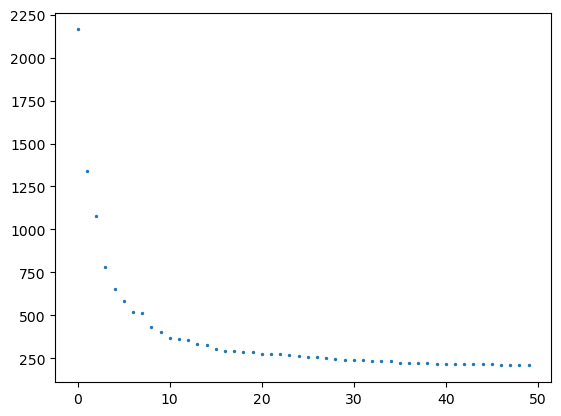

In [28]:
residence_time_lig = np.sort(np.array([len(i) for i in events_lig]))[::-1]
plt.scatter(np.arange(50), residence_time_lig[:50]*180e-3, s = 2)

In [30]:
residence_time_lig[0]*.18

2163.7799999999997

In [7]:
events_fas = residence_events(dmat_fas,condition)
events_fas.sort(key=len, reverse = True)

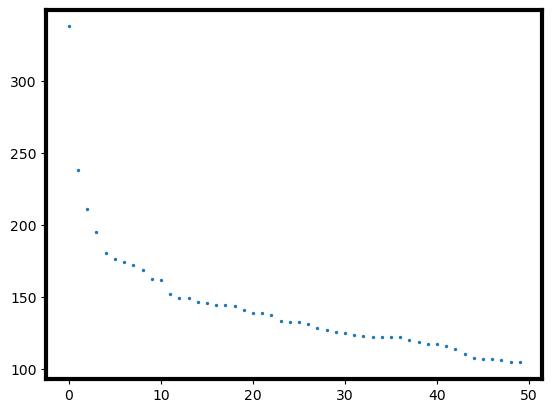

In [8]:
residence_time_fas = np.sort(np.array([len(i) for i in events_fas]))[::-1]
plt.scatter(np.arange(50), residence_time_fas[:50]*180e-3, s = 2)

Text(0.5, -0.1, 'Residues')

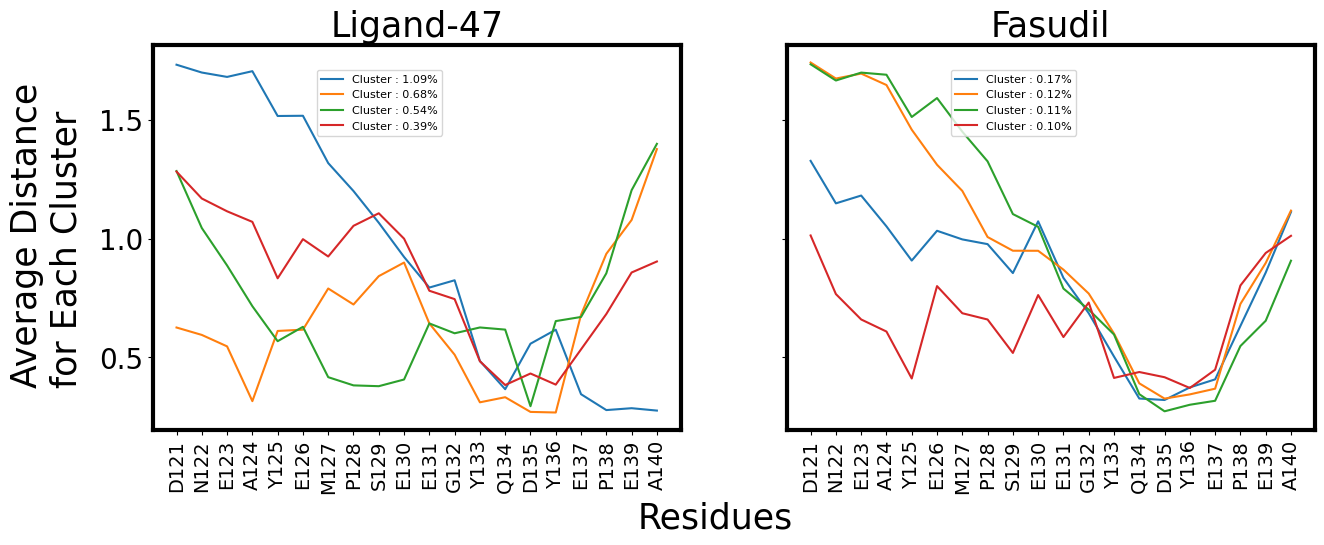

In [17]:
xlabel = 'Residues'
ylabel = 'Average Distance\nfor Each Cluster'

fig,ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(15, 5))


for i in events_lig[:4]:
    ax[0].plot(dmat_lig[i].mean(0), label = f"Cluster : {100*len(i)/len(dmat_lig):.2f}%")
    ax[0].legend(ncol = 1, prop={'size': 8}, bbox_to_anchor=(0.3, 0.75, 0., 0.))
    ax[0].tick_params(axis='y', labelsize=20)
    ax[0].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],('D121','N122','E123','A124','Y125','E126','M127','P128','S129','E130','E131','G132','Y133','Q134','D135','Y136','E137','P138','E139','A140'), rotation=90, fontsize = 14)
    ax[0].set_title("Ligand-47",size=25)
for i in events_fas[:4]:
    ax[1].plot(dmat_fas[i].mean(0), label = f"Cluster : {100*len(i)/len(dmat_fas):.2f}%")
    ax[1].legend(ncol = 1, prop={'size': 8}, bbox_to_anchor=(0.3, 0.75, 0., 0.))
    ax[1].tick_params(axis='y', labelsize=20)
    ax[1].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],('D121','N122','E123','A124','Y125','E126','M127','P128','S129','E130','E131','G132','Y133','Q134','D135','Y136','E137','P138','E139','A140'), rotation=90, fontsize = 14)
    ax[1].set_title("Fasudil",size=25)
fig.supylabel(ylabel,x = 0.03,fontsize = 25)
fig.supxlabel(xlabel,y = -0.1,fontsize = 25)    

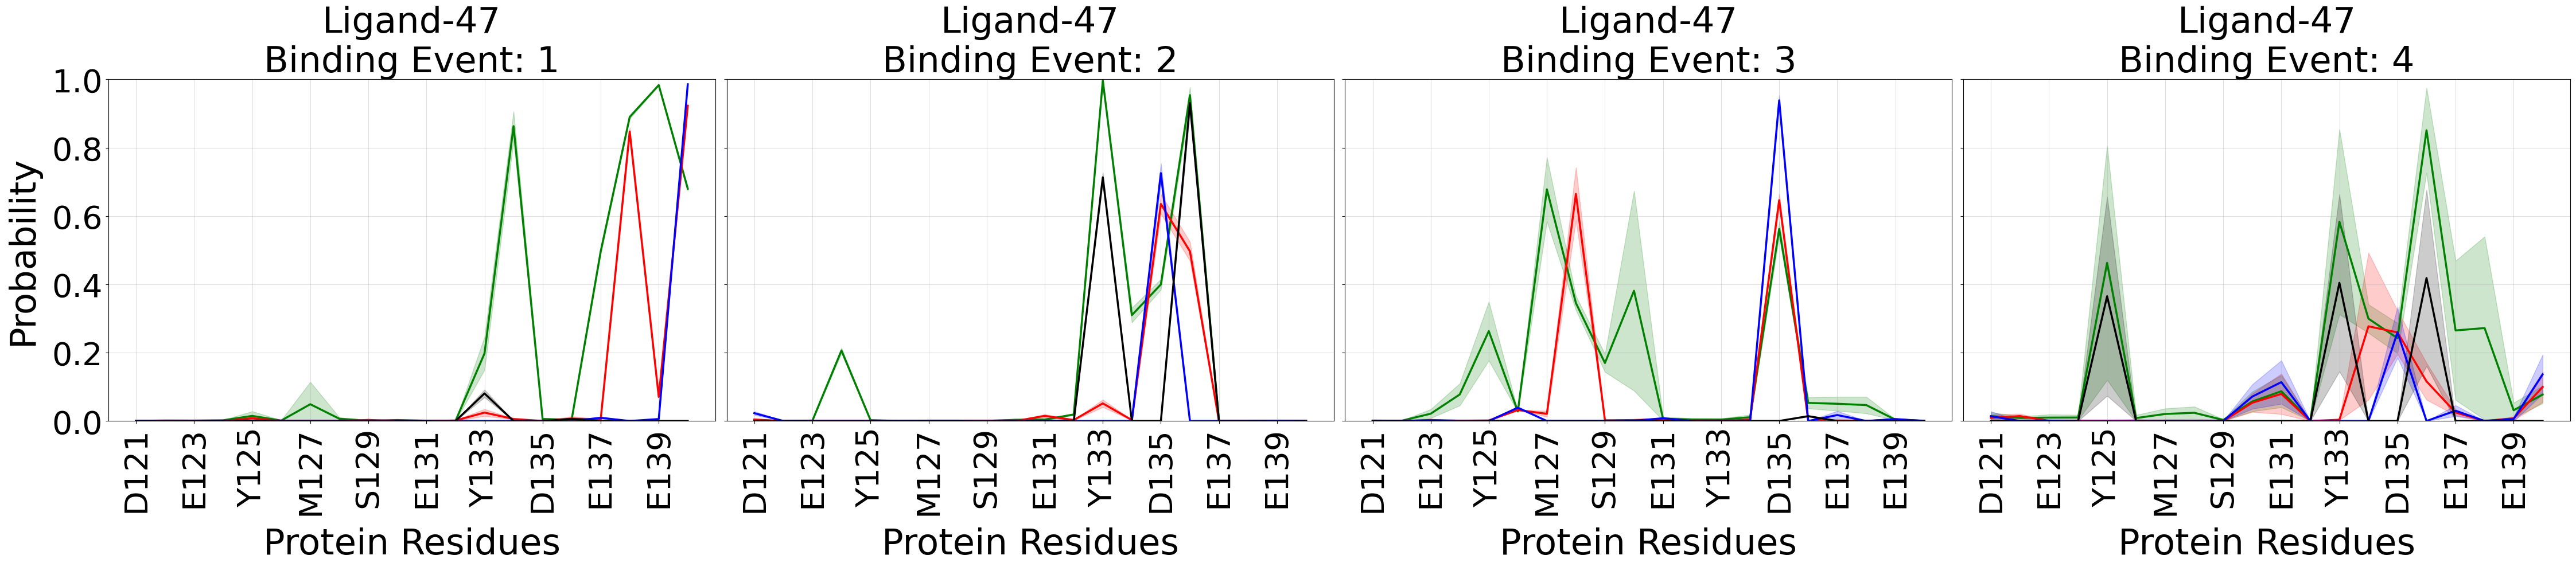

In [4]:
Hbond= np.load("intermol_binding_Hbond_pcca_lig.npy" )
charge_= np.load("intermol_binding_charge_pcca_lig.npy")
aro_ = np.load("intermol_binding_aro_pcca_lig.npy")
hydro = np.load("intermol_binding_hydro_pcca_lig.npy")

fig, ax = plt.subplots(1, 4, figsize=(45, 10), sharex=True, sharey=True)
#res = np.array([str(trj[0].topology.residue(i)) for i in range(20)])
res_ = ('D121','E123','Y125','M127','S129','E131','Y133','D135','E137','E139')

for i in range(4):
    p = np.unravel_index(i,(4))
    
    ax[p].plot(hydro[i].T[0], hydro[i].T[1], linewidth=2.5, label='Hydrophobic Contacts', color='green')
    ax[p].fill_between(hydro[i].T[0], hydro[i].T[1]-hydro[i].T[2],
                          hydro[i].T[1]+hydro[i].T[2], alpha=0.2,color='green')
    
    ax[p].plot(Hbond[i].T[0], Hbond[i].T[1], linewidth=2.5,label='Hydrogen Bond', color='red')
    ax[p].fill_between(Hbond[i].T[0], Hbond[i].T[1]-Hbond[i].T[2],
                          Hbond[i].T[1]+Hbond[i].T[2], alpha=0.2,color='r')
    
    ax[p].plot(charge_[i].T[0], charge_[i].T[1], linewidth=2.5,label='Charge Contacts',c='blue')
    ax[p].fill_between(charge_[i].T[0], charge_[i].T[1]-charge_[i].T[2],
                          charge_[i].T[1]+charge_[i].T[2], alpha=0.2,color='blue')
    
    ax[p].plot(aro_[i].T[0], aro_[i].T[1], linewidth=2.5, color='black', label='Aromatic Stacking')
    ax[p].fill_between(aro_[i].T[0], aro_[i].T[1]-aro_[i].T[2],
                         aro_[i].T[1]+aro_[i].T[2], alpha=0.2,color='black')
    
    ax[p].set_ylim(0,1.0)
    ax[p].set_xticks(range(int(min(Hbond[i][:,0])),int(max(Hbond[i][:,0])+1),2))
    ax[p].set_xticklabels(res_)
    ax[p].tick_params(labelsize=40)
    ax[p].grid(alpha=0.4)
    plt.setp(ax[p].get_xticklabels(), rotation=90)
    
    
    #if i == 3:
        #ax[p].legend(loc=1,prop={'size': 42})

    a='Ligand-47\nBinding Event: '+str(i+1)
    ax[p].set_title(a,size=45)
    
    #text_=r'$K_{D}$'+' : '+str(round(K[2][i],2))+r'$\pm$'+str(round(K[3][i],2))
    #ax[p].text(120.3, 0.63, text_, fontsize = 26)
    
    ax[0].set_ylabel("Probability", size=45, labelpad=15)
    ax[p].set_xlabel('Protein Residues', size=45, labelpad=15)
        
plt.tight_layout()

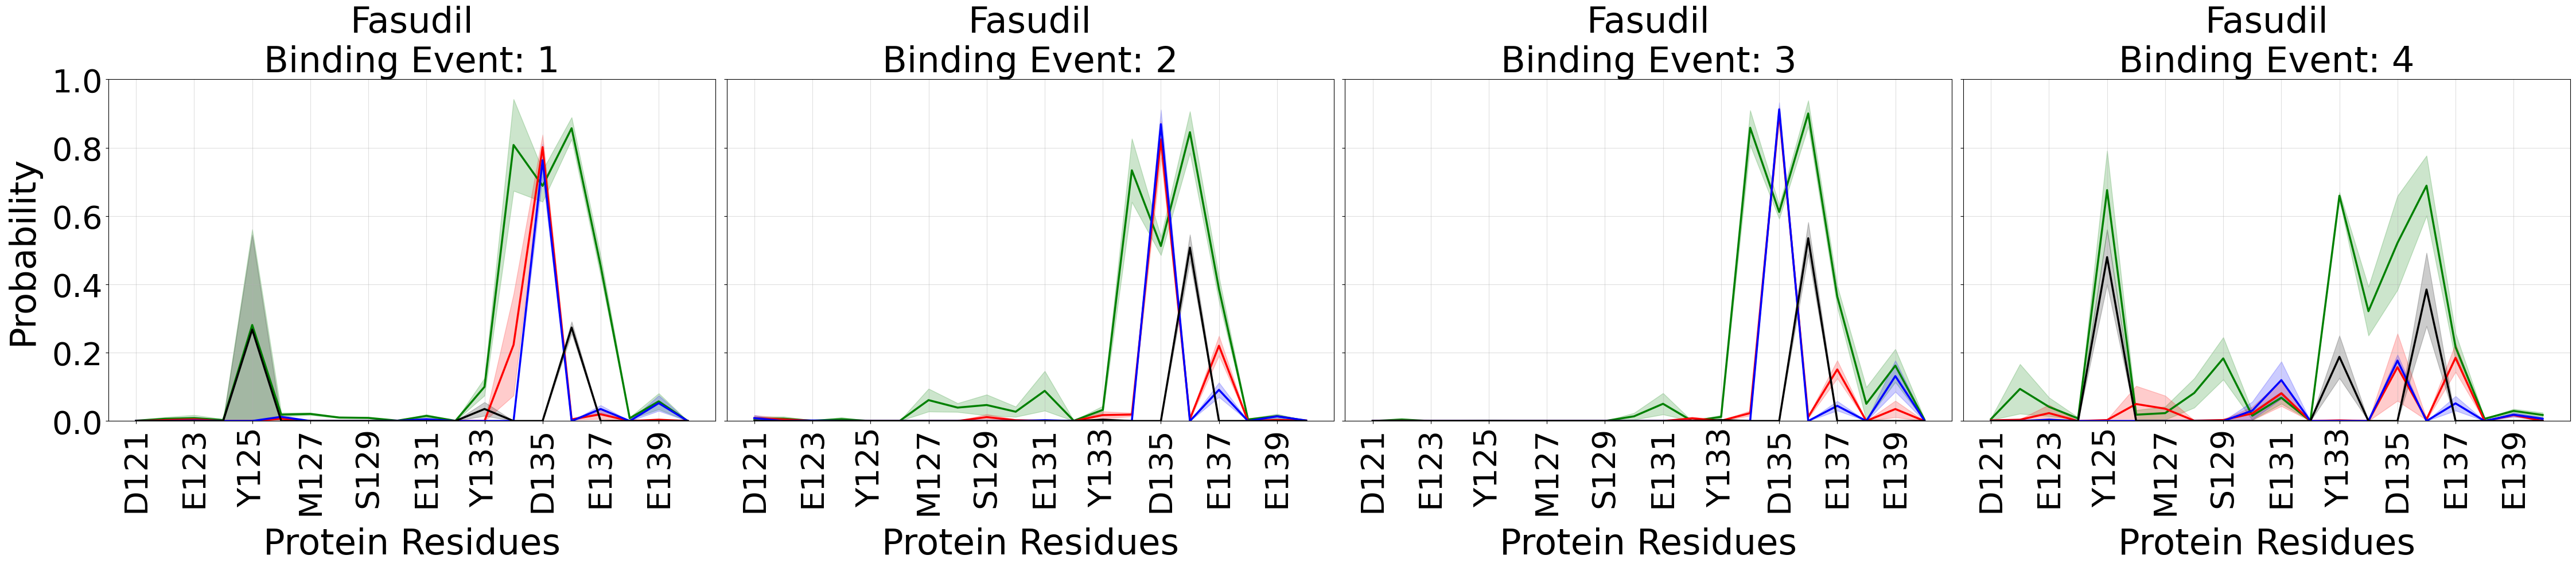

In [7]:
Hbond= np.load("/data/asn/tica/fasudil/combined/intermol_binding_Hbond_pcca_fas.npy" )
charge_= np.load("/data/asn/tica/fasudil/combined/intermol_binding_charge_pcca_fas.npy")
aro_ = np.load("/data/asn/tica/fasudil/combined/intermol_binding_aro_pcca_fas.npy")
hydro = np.load("/data/asn/tica/fasudil/combined/intermol_binding_hydro_pcca_fas.npy")


fig, ax = plt.subplots(1, 4, figsize=(45, 10), sharex=True, sharey=True)
#res = np.array([str(trj[0].topology.residue(i)) for i in range(20)])
res_ = ('D121','E123','Y125','M127','S129','E131','Y133','D135','E137','E139')

for i in range(4):
    p = np.unravel_index(i,(4))
    
    ax[p].plot(hydro[i].T[0], hydro[i].T[1], linewidth=2.5, label='Hydrophobic Contacts', color='green')
    ax[p].fill_between(hydro[i].T[0], hydro[i].T[1]-hydro[i].T[2],
                          hydro[i].T[1]+hydro[i].T[2], alpha=0.2,color='green')
    
    ax[p].plot(Hbond[i].T[0], Hbond[i].T[1], linewidth=2.5,label='Hydrogen Bond', color='red')
    ax[p].fill_between(Hbond[i].T[0], Hbond[i].T[1]-Hbond[i].T[2],
                          Hbond[i].T[1]+Hbond[i].T[2], alpha=0.2,color='r')
    
    ax[p].plot(charge_[i].T[0], charge_[i].T[1], linewidth=2.5,label='Charge Contacts',c='blue')
    ax[p].fill_between(charge_[i].T[0], charge_[i].T[1]-charge_[i].T[2],
                          charge_[i].T[1]+charge_[i].T[2], alpha=0.2,color='blue')
    
    ax[p].plot(aro_[i].T[0], aro_[i].T[1], linewidth=2.5, color='black', label='Aromatic Stacking')
    ax[p].fill_between(aro_[i].T[0], aro_[i].T[1]-aro_[i].T[2],
                         aro_[i].T[1]+aro_[i].T[2], alpha=0.2,color='black')
    
    ax[p].set_ylim(0,1.0)
    ax[p].set_xticks(range(int(min(Hbond[i][:,0])),int(max(Hbond[i][:,0])+1),2))
    ax[p].set_xticklabels(res_)
    ax[p].tick_params(labelsize=40)
    ax[p].grid(alpha=0.4)
    plt.setp(ax[p].get_xticklabels(), rotation=90)
    
    
    #if i == 3:
        #ax[p].legend(loc=1,prop={'size': 42})

    a='Fasudil\nBinding Event: '+str(i+1)
    ax[p].set_title(a,size=45)
    
    #text_=r'$K_{D}$'+' : '+str(round(K[2][i],2))+r'$\pm$'+str(round(K[3][i],2))
    #ax[p].text(120.3, 0.63, text_, fontsize = 26)
    
    ax[0].set_ylabel("Probability", size=45, labelpad=15)
    ax[p].set_xlabel('Protein Residues', size=45, labelpad=15)
        
plt.tight_layout()

Text(1618.4027777777778, 0.5, 'Contact Probability')

<Figure size 640x480 with 0 Axes>

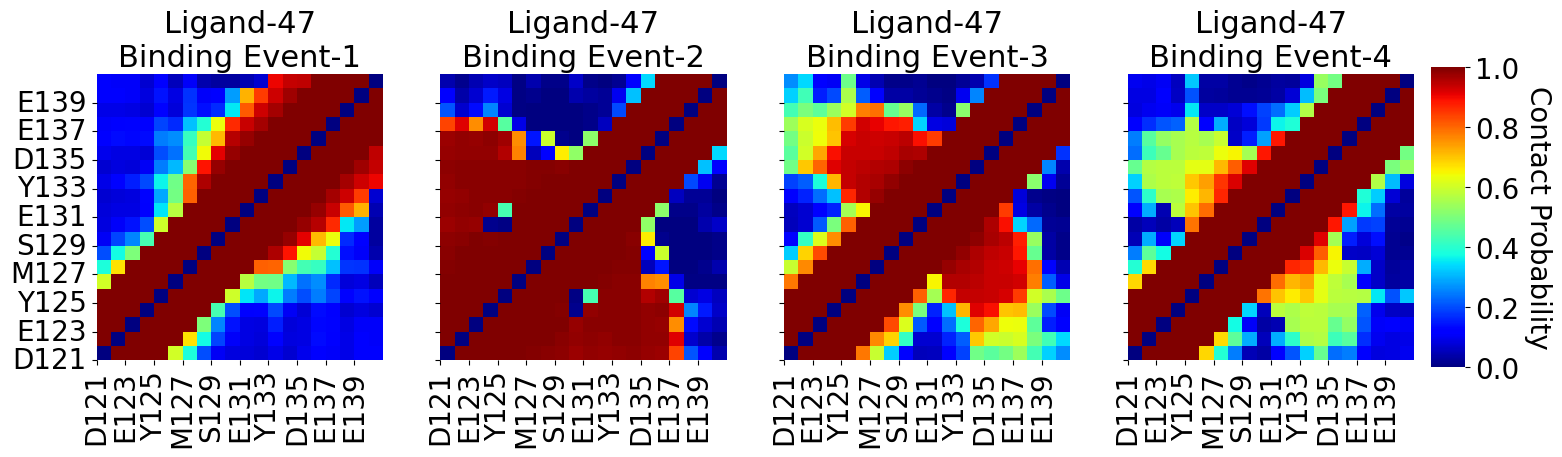

In [22]:
C = np.load("pep_contact_binding_event_lig.npy")
res_ = ('D121','E123','Y125','M127','S129','E131','Y133','D135','E137','E139')
#title = 'Mutual Information \n Charge-contacts - Intermolecular-distances'
#xlabel = 'Intermolecular-distances'
#ylabel = 'Charge-contacts'
plt.subplots_adjust(wspace=0.01, hspace=1)
ncol = 4
nrow = 1
fig, ax = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(17, 4))
cbar_ax = fig.add_axes([.91, .12, .02, .75])
for i in range(4):
    #contact_map = np.loadtxt(f"./Analysis/contact_map.{i}.dat")
    contact_map = C[i]
    p = np.unravel_index(i,(5))
    cb = i==1
    plot = sns.heatmap(contact_map, ax=ax[p], vmin = 0, vmax= 1, cmap = "jet",  cbar=cb, cbar_ax=cbar_ax)
                  #xticklabels = res, yticklabels = charge_res)
    #cbar = ax.collections[0].colorbar
    #cbar.set_label(label = "MI",size = 15)
    #cbar.ax.tick_params(labelsize=15)
    ax[p].invert_yaxis()
    ax[p].tick_params(axis = 'x', rotation = 90)
    ax[p].set_title('Ligand-47\nBinding Event-'+str(i+1),size=22)
    ax[p].set_aspect('equal', 'box')
    ax[p].set_xticks(range(0, 20,2), res_, rotation=90, size=20)
    ax[p].set_yticks(range(0, 20,2), res_, rotation=0, size=20)
    #ax[p].set_xlabel(xlabel, size = 15)
    #ax[p].set_ylabel(ylabel, size = 15)
cbar_ax.tick_params(labelsize=20)
cbar_ax.set_ylabel('Contact Probability', rotation=270, fontsize = 20, labelpad=24)
#plt.savefig('Lig47_pep_contact_binding.png', bbox_inches="tight")

Text(1618.4027777777778, 0.5, 'Contact Probability')

<Figure size 640x480 with 0 Axes>

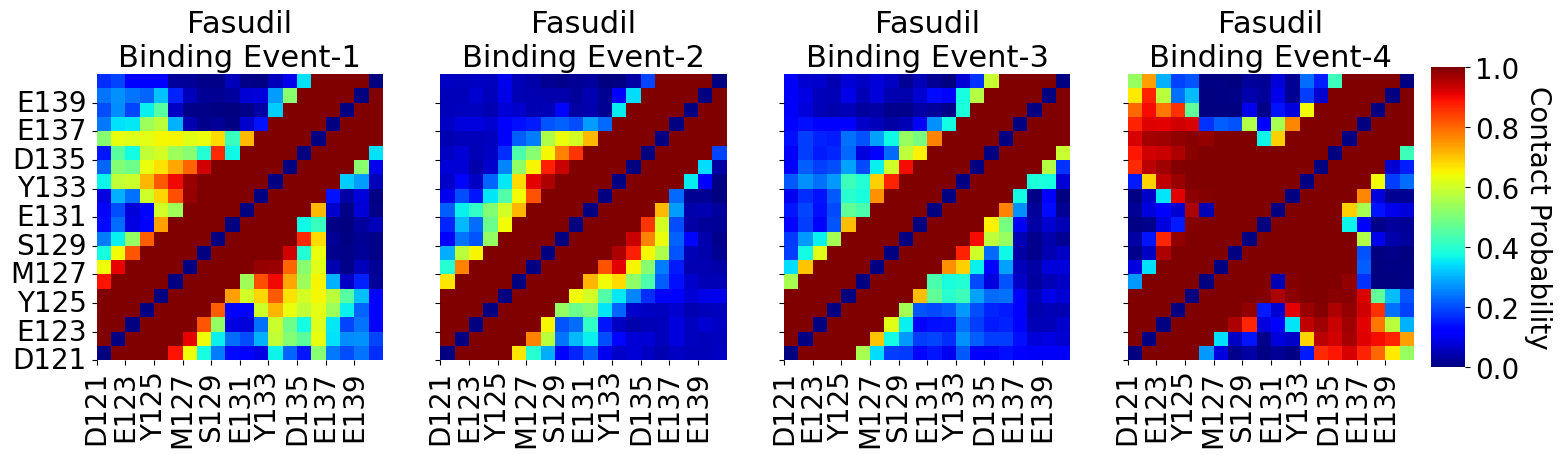

In [23]:
C = np.load("/data/asn/tica/fasudil/combined/pep_contact_binding_event_fas.npy")
res_ = ('D121','E123','Y125','M127','S129','E131','Y133','D135','E137','E139')
#title = 'Mutual Information \n Charge-contacts - Intermolecular-distances'
#xlabel = 'Intermolecular-distances'
#ylabel = 'Charge-contacts'
plt.subplots_adjust(wspace=0.01, hspace=1)
ncol = 4
nrow = 1
fig, ax = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(17, 4))
cbar_ax = fig.add_axes([.91, .12, .02, .75])
for i in range(4):
    #contact_map = np.loadtxt(f"./Analysis/contact_map.{i}.dat")
    contact_map = C[i]
    p = np.unravel_index(i,(5))
    cb = i==1
    plot = sns.heatmap(contact_map, ax=ax[p], vmin = 0, vmax= 1, cmap = "jet",  cbar=cb, cbar_ax=cbar_ax)
                  #xticklabels = res, yticklabels = charge_res)
    #cbar = ax.collections[0].colorbar
    #cbar.set_label(label = "MI",size = 15)
    #cbar.ax.tick_params(labelsize=15)
    ax[p].invert_yaxis()
    ax[p].tick_params(axis = 'x', rotation = 90)
    ax[p].set_title('Fasudil\nBinding Event-'+str(i+1),size=22)
    ax[p].set_aspect('equal', 'box')
    ax[p].set_xticks(range(0, 20,2), res_, rotation=90, size=20)
    ax[p].set_yticks(range(0, 20,2), res_, rotation=0, size=20)
    #ax[p].set_xlabel(xlabel, size = 15)
    #ax[p].set_ylabel(ylabel, size = 15)
cbar_ax.tick_params(labelsize=20)
cbar_ax.set_ylabel('Contact Probability', rotation=270, fontsize = 20, labelpad=24)
#plt.savefig('Lig47_pep_contact_binding.png', bbox_inches="tight")

In [33]:
residence_time_lig[0]*.18

2163.7799999999997

In [34]:
residence_time_lig[1]*.18

1337.76

In [35]:
residence_time_lig[2]*.18

1078.2

<Figure size 640x480 with 0 Axes>

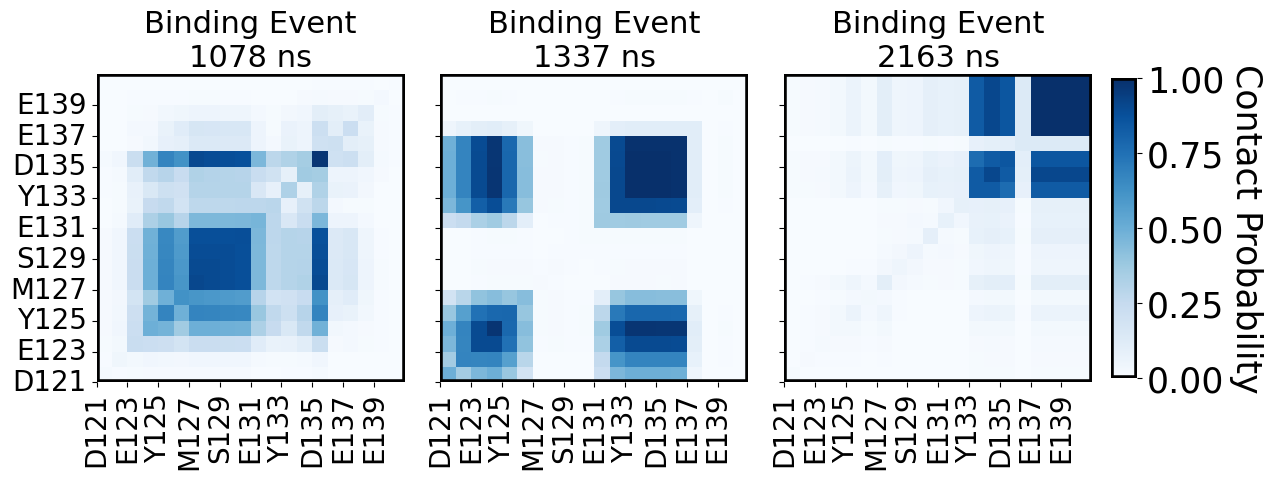

In [51]:
C_ = np.load("dual_contact_binding_event_lig.npy")
order = [2,1,0,3]
C__=C_[order]
res_ = ('D121','E123','Y125','M127','S129','E131','Y133','D135','E137','E139')
#title = 'Mutual Information \n Charge-contacts - Intermolecular-distances'
#xlabel = 'Intermolecular-distances'
#ylabel = 'Charge-contacts'
plt.subplots_adjust(wspace=0.01, hspace=1)
ncol = 3
nrow = 1
fig, ax = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(13, 4))
cbar_ax = fig.add_axes([.91, .12, .02, .75])
for i in range(3):
    #contact_map = np.loadtxt(f"./Analysis/contact_map.{i}.dat")
    contact_map = C__[i]
    p = np.unravel_index(i,(4))
    cb = i==1
    plot = sns.heatmap(contact_map, ax=ax[p], vmin = 0, vmax= 1, cmap = "Blues",  cbar=cb, cbar_ax=cbar_ax)
                  #xticklabels = res, yticklabels = charge_res)
    #cbar = ax.collections[0].colorbar
    #cbar.set_label(label = "MI",size = 15)
    #cbar.ax.tick_params(labelsize=15)
    ax[p].invert_yaxis()
    ax[p].tick_params(axis = 'x', rotation = 90)
    #ax[p].set_title('Ligand-47\nBinding Event-'+str(i+1),size=22)
    ax[p].set_aspect('equal', 'box')
    ax[p].set_xticks(range(0, 20,2), res_, rotation=90, size=20)
    ax[p].set_yticks(range(0, 20,2), res_, rotation=0, size=20)
    ax[p].axhline(y=0, color='k',linewidth=4)
    ax[p].axhline(y=contact_map.shape[1], color='k',linewidth=4)
    ax[p].axvline(x=0, color='k',linewidth=4)
    ax[p].axvline(x=contact_map.shape[0], color='k',linewidth=4)
    #ax[p].set_xlabel(xlabel, size = 15)
    #ax[p].set_ylabel(ylabel, size = 15)
    ax[0].set_title('Binding Event\n1078 ns',size=22)
    ax[1].set_title('Binding Event\n1337 ns',size=22)
    ax[2].set_title('Binding Event\n2163 ns',size=22)
cbar_ax.tick_params(labelsize=25)
cbar_ax.set_ylabel('Contact Probability', rotation=270, fontsize = 25, labelpad=28)

cbar_ax.axhline(y=0, color='k',linewidth=4)
cbar_ax.axhline(y=1, color='k',linewidth=4)
cbar_ax.axvline(x=0, color='k',linewidth=4)
cbar_ax.axvline(x=1, color='k',linewidth=4)
#plt.savefig('Lig47_dual_contact_binding.png', bbox_inches="tight")
plt.subplots_adjust(wspace=0.075)

<Figure size 640x480 with 0 Axes>

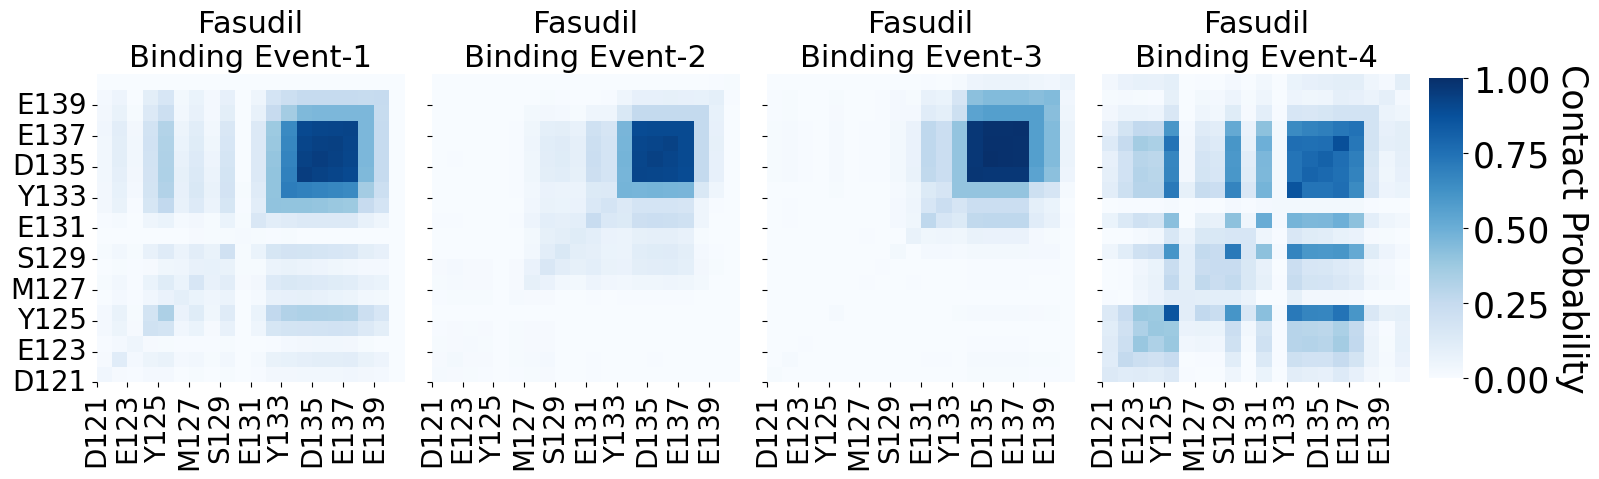

In [18]:
C_ = np.load("/data/asn/tica/fasudil/combined/dual_contact_binding_event_fas.npy")
order = [0,2,1,3]
C__=aro_[order]
res_ = ('D121','E123','Y125','M127','S129','E131','Y133','D135','E137','E139')
#title = 'Mutual Information \n Charge-contacts - Intermolecular-distances'
#xlabel = 'Intermolecular-distances'
#ylabel = 'Charge-contacts'
plt.subplots_adjust(wspace=0.01, hspace=1)
ncol = 4
nrow = 1
fig, ax = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(17, 4))
cbar_ax = fig.add_axes([.91, .12, .02, .75])
for i in range(4):
    #contact_map = np.loadtxt(f"./Analysis/contact_map.{i}.dat")
    contact_map = C__[i]
    p = np.unravel_index(i,(5))
    cb = i==1
    plot = sns.heatmap(contact_map, ax=ax[p], vmin = 0, vmax= 1, cmap = "Blues",  cbar=cb, cbar_ax=cbar_ax)
                  #xticklabels = res, yticklabels = charge_res)
    #cbar = ax.collections[0].colorbar
    #cbar.set_label(label = "MI",size = 15)
    #cbar.ax.tick_params(labelsize=15)
    ax[p].invert_yaxis()
    ax[p].tick_params(axis = 'x', rotation = 90)
    ax[p].set_title('Fasudil\nBinding Event-'+str(i+1),size=22)
    ax[p].set_aspect('equal', 'box')
    ax[p].set_xticks(range(0, 20,2), res_, rotation=90, size=20)
    ax[p].set_yticks(range(0, 20,2), res_, rotation=0, size=20)
    #ax[p].set_xlabel(xlabel, size = 15)
    #ax[p].set_ylabel(ylabel, size = 15)
cbar_ax.tick_params(labelsize=25)
cbar_ax.set_ylabel('Contact Probability', rotation=270, fontsize = 25, labelpad=28)
#plt.savefig('Lig47_dual_contact_binding.png', bbox_inches="tight")
plt.subplots_adjust(wspace=0.075)